In [1]:
import numpy as np
from scipy import stats, sparse
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import igraph

In [2]:
adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_synaptome.npz'
adj = sparse.load_npz(adj_path)
adj = adj[:adj.shape[1],:]

In [3]:
adj

<456378x456378 sparse matrix of type '<class 'numpy.float64'>'
	with 156661043 stored elements in Compressed Sparse Column format>

In [4]:
connectome = adj.copy()
connectome[connectome > 0] = 1

In [ ]:
def density(adjacency):
    return adjacency.sum() / (adjacency.shape[0] * (adjacency.shape[0]-1))

In [5]:
density(connectome)

0.0007521640349826303

In [7]:
syns_per_conn = adj[adj>0]

KeyboardInterrupt: 

In [6]:
syns_per_conn.var()

NameError: name 'syns_per_conn' is not defined

In [141]:
connectome.sum(axis=0).max()

3008.0

In [145]:
connectome.sum(axis=1).max()

5130.0

In [150]:
print(adj.sum(axis=1).mean(),adj.sum(axis=1).std())

1798.6576040036987 4297.292360012757


In [155]:
adj.sum(axis=1).max()

34972.0

In [148]:
print(connectome.sum(axis=1).mean(),connectome.sum(axis=1).std())

343.27036579326784 430.35549828346694


In [139]:
connectome[:3,:4].sum(axis=0)

matrix([[0., 0., 0., 0.]])

In [27]:
class DegreeDistributionAnalyzer:
    def __init__(self, adjacency_matrix):
        self.adjacency_matrix = adjacency_matrix
        self.is_lognormal_in = None
        self.is_lognormal_out = None
        self.is_lognormal_tot = None

    def get_degrees(self, kind):
        """
        Compute and return the desired degrees (in-degrees, out-degrees, or total degrees).
        """
        degrees = None
        
        if kind == 'in':
            degrees = np.array(self.adjacency_matrix.sum(axis=0)).flatten()
        elif kind == 'out':
            degrees = np.array(self.adjacency_matrix.sum(axis=1)).flatten()
        elif kind == 'total':
            in_degrees = np.array(self.adjacency_matrix.sum(axis=0)).flatten()
            out_degrees = np.array(self.adjacency_matrix.sum(axis=1)).flatten()
            degrees = in_degrees + out_degrees
        else:
            raise ValueError("Invalid degree type. Choose 'in', 'out', or 'total'.")
        
        degrees = degrees[degrees > 0]  # Remove zero degrees
        return degrees

    def fit_degree_distribution(self, degrees, distributions):
        """
        Fit the degree distribution to multiple statistical distributions and determine the best fit.
        """
        best_fit = None
        best_params = None
        best_sse = np.inf
        
        for distribution in distributions:
            # Fit the distribution to the degrees
            params = distribution.fit(degrees)
            sse = self.calculate_sse(degrees, distribution, params)
            
            # Check if the current fit is better than the previous best
            if sse < best_sse:
                best_fit = distribution
                best_params = params
                best_sse = sse
        
        return best_fit, best_params, best_sse
    
    def calculate_sse(self, degrees, distribution, params):
        """
        Calculate the sum of squared errors (SSE) between the observed degrees and the fitted distribution.
        """
        fitted_degrees = distribution.pdf(degrees, *params)
        sse = np.sum((degrees - fitted_degrees) ** 2)
        return sse

    def check_best_fit(self, distributions, kind):
        """
        Find the best-fitting distribution for the degree distribution.
        """
        degrees = self.get_degrees(kind)
        
        best_fit, best_params, best_sse = self.fit_degree_distribution(degrees, distributions)
        
        return best_fit, best_params, best_sse

    def plot_degree_distribution(self, degrees, distribution, params, sse):
        """
        Plot the degree distribution along with the fitted curve and R-squared value.
        """
        plt.hist(degrees, bins='auto', density=True, alpha=0.5, label='Degree Distribution')
        x = np.linspace(np.min(degrees), np.max(degrees), 100)
        fitted_curve = distribution.pdf(x, *params)
        plt.plot(x, fitted_curve, 'r-', label='Best Fit Curve')
        plt.xlabel('Degree')
        plt.ylabel('Probability Density')
        plt.title('Degree Distribution with Best Fit')
        plt.legend()

        # Calculate R-squared value
        y_mean = np.mean(degrees)
        sst = np.sum((degrees - y_mean) ** 2)
        ssr = np.sum((degrees - distribution.pdf(degrees, *params)) ** 2)
        r_squared = 1 - (ssr / sst)
        plt.text(0.7, 0.8, f'R-squared: {r_squared:.4f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black'))

        plt.show()
    
    def check_lognormality(self,alpha=1e-3):
        """
        Check the lognormality of the in and out degree distributions using statistical methods.

        alpha : if p<alpha : reject the null hypothesis that the distribution is normal.
        """
        in_degrees, out_degrees,tot_degrees = self.get_degrees('in'),self.get_degrees('out'),self.get_degrees('total')

        # Compute log-transformed degrees
        log_in_degrees = np.log(in_degrees)
        log_out_degrees = np.log(out_degrees)
        log_tot_degrees = np.log(tot_degrees)

        # Perform statistical tests for lognormality
        in_lognormal, in_pvalue = stats.normaltest(log_in_degrees)
        out_lognormal, out_pvalue = stats.normaltest(log_out_degrees)
        tot_lognormal, tot_pvalue = stats.normaltest(log_tot_degrees)

#         print("p = {:g}".format(p))
        if in_pvalue < alpha:  # null hypothesis: x comes from a normal distribution
            print("Indegree: The null hypothesis can be rejected")
            self.is_lognormal_in = False
        else:
            print("Indegree: The null hypothesis cannot be rejected")
            self.is_lognormal_in = True

        if out_pvalue < alpha:  # null hypothesis: x comes from a normal distribution
            print("Outdegree: The null hypothesis can be rejected")
            self.is_lognormal_out = False
        else:
            print("Outdegree: The null hypothesis cannot be rejected")
            self.is_lognormal_out = True

        if tot_pvalue < alpha:  # null hypothesis: x comes from a normal distribution
            print("Total degree: The null hypothesis can be rejected")
            self.is_lognormal_tot = False
        else:
            print("Total degree: The null hypothesis cannot be rejected")
            self.is_lognormal_tot = True

#         return self.is_lognormal_in,self.is_lognormal_out,self.is_lognormal_tot
        return in_pvalue,out_pvalue,tot_pvalue

    def calculate_power_law(self, degrees):
        """
        Calculate the power-law distribution and estimate the slope of the degree distribution.
        """
        degrees = degrees.astype(int)  # Convert to integers

        # Remove zero-degree values
        nonzero_degrees = degrees[degrees > 0]
        np.testing.assert_array_equal(degrees,nonzero_degrees)
        
        log_degrees = np.log10(nonzero_degrees)
        log_probs = np.log10(np.bincount(nonzero_degrees)) - np.log10(len(nonzero_degrees))
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_degrees, log_probs)
        return slope
    
    def plot_loglog_degree_distribution(self, degrees):
        """
        Plot the log-log degree distribution and estimate the slope.
        """
        log_degrees = np.log10(degrees)
        log_probs = np.log10(np.bincount(degrees)) - np.log10(len(degrees))
        slope = self.calculate_power_law(degrees)
        
        plt.plot(log_degrees, log_probs, 'bo', markersize=3)
        plt.xlabel('log(Degree)')
        plt.ylabel('log(Probability)')
        plt.title('Log-Log Degree Distribution')
        
        plt.text(0.1, 0.9, f'Slope: {slope:.4f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black'))
        
        plt.show()

    def plot_log_binned_degree_distribution(self, kind='total', cumulative=False, title=None, fit_min_degree=10):
        degrees = self.get_degrees(kind)
        degree_counts = dict(Counter(degrees))
        max_degree = np.max(list(degree_counts.keys()))

        # Generate logarithmically spaced bins
        log_bins = np.logspace(0, np.log10(max_degree), num=20)  # Adjust num as required

        # Compute histogram with log bins
        hist, bins = np.histogram(degrees, bins=log_bins, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2

        if cumulative:
            hist = np.cumsum(hist[::-1])[::-1]  # Reverse, compute cumulative sum, then reverse back

        # Plot degree distribution in log-log scale
        plt.figure(figsize=(7, 6))
        plt.loglog(bin_centers, hist, 'bo', markersize=5)

        # Calculate linear regression in log-log scale for high degrees only
        fit_indices = bin_centers >= fit_min_degree
        slope, intercept, r_value, p_value, std_err = linregress(np.log10(bin_centers[fit_indices]), np.log10(hist[fit_indices]))
        x_fit = np.linspace(np.log10(fit_min_degree), np.max(np.log10(bin_centers)), num=100)
        y_fit = intercept + slope * x_fit
        plt.plot(10 ** x_fit, 10 ** y_fit, 'r-')

        # Add text box with slope and R-squared
        textstr = f'Slope: {slope:.2f}\n$R^2$: {r_value**2:.2f}'
        plt.text(0.80, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.xlabel('Degree (k)')
        if cumulative:
            plt.ylabel('Cumulative Probability (P(K>=k))')
            if title:
                plt.title(title)
            else:
                plt.title(f'Log-Binned Cumulative {kind}-Degree Distribution')
        else:
            plt.ylabel('Probability (P(k))')
            if title:
                plt.title(title)
            else:
                plt.title(f'Log-Binned {kind}-Degree Distribution')

        plt.show()
        
        return slope




In [9]:
adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_ca3_to_slice10_synaptome.npz'
adj_matrix = sparse.load_npz(adj_path)
adj_matrix = adj_matrix[:adj_matrix.shape[1],:]
connectome = adj_matrix.copy()
connectome[connectome>1]=1

In [15]:
adj_matrix

<12615x12615 sparse matrix of type '<class 'numpy.float64'>'
	with 2779593 stored elements in Compressed Sparse Column format>

In [16]:
isinstance(adj_matrix,sparse.csc_matrix)

True

In [42]:
adj

<456378x456378 sparse matrix of type '<class 'numpy.float64'>'
	with 156661043 stored elements in Compressed Sparse Column format>

In [22]:
# Create an instance of DegreeDistributionAnalyzer
analyzer = DegreeDistributionAnalyzer(adj)

In [23]:
# Check lognormality of the degree distributions
analyzer.check_lognormality(alpha=1e-3)

Indegree: The null hypothesis can be rejected
Outdegree: The null hypothesis can be rejected
Total degree: The null hypothesis can be rejected


(0.0, 0.0, 0.0)

In [24]:
from scipy.stats import norm, lognorm, expon, gamma

# Define the list of distributions to test
distributions = [norm, lognorm, expon, gamma]

Best fit for in-degree distribution: gamma
Best parameters for in-degree ditribution: (5.020246623225621, -16.820496230268795, 361.6312621604015)
SSE for in-degree distribution: 1891011670349.1147


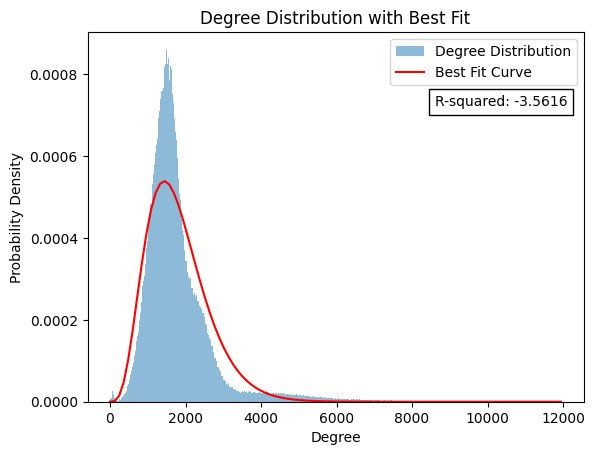

In [25]:
# Find the best-fitting distributions for the degree distributions
best_fit_in, best_params_in, best_sse_in = analyzer.check_best_fit(distributions,kind='in')
in_degrees = analyzer.get_degrees('in')

print("Best fit for in-degree distribution:", best_fit_in.name)
print("Best parameters for in-degree ditribution:", best_params_in)
print("SSE for in-degree distribution:", best_sse_in)

# Plot the in-degree distribution
analyzer.plot_degree_distribution(in_degrees, best_fit_in, best_params_in, best_sse_in)

Best fit for out-degree distribution: lognorm
Best parameters for out-degree distribution: (1.1611717943152726, 3.719772217022093, 421.02652028176374)
SSE for out-degree distribution: 132065627840.07819


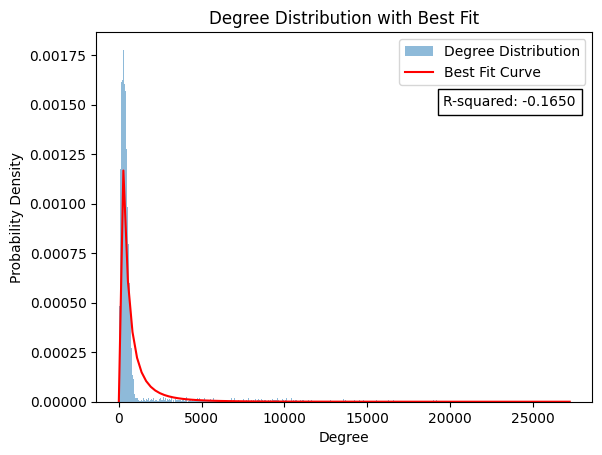

In [8]:
# Find the best-fitting distributions for the outdegree distribution
best_fit_out, best_params_out, best_sse_out = analyzer.check_best_fit(distributions, kind='out')
out_degrees = analyzer.get_degrees('out')

print("Best fit for out-degree distribution:", best_fit_out.name)
print("Best parameters for out-degree distribution:", best_params_out)
print("SSE for out-degree distribution:", best_sse_out)

# Plot the out-degree distribution
analyzer.plot_degree_distribution(out_degrees, best_fit_out, best_params_out, best_sse_out)


Best fit for tot-degree distribution: lognorm
Best parameters for tot-degree distribution: (0.7645335650099616, 124.08467400095853, 1511.8481384988854)
SSE for tot-degree distribution: 219076255851.67523


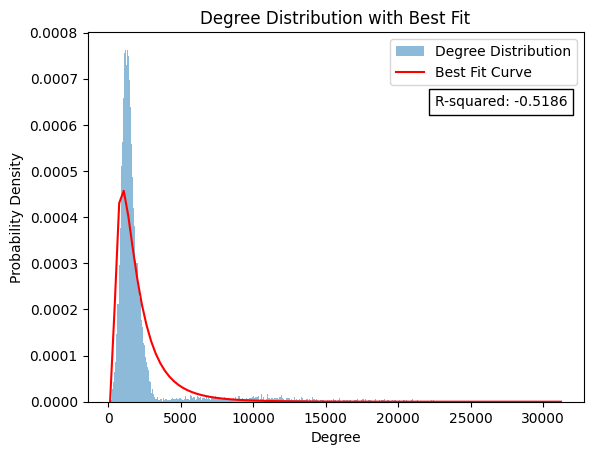

In [9]:
# Find the best-fitting distributions for the outdegree distribution
best_fit_tot, best_params_tot, best_sse_tot = analyzer.check_best_fit(distributions, kind='total')
tot_degrees = analyzer.get_degrees('total')

print("Best fit for tot-degree distribution:", best_fit_tot.name)
print("Best parameters for tot-degree distribution:", best_params_tot)
print("SSE for tot-degree distribution:", best_sse_tot)

# Plot the out-degree distribution
analyzer.plot_degree_distribution(tot_degrees, best_fit_tot, best_params_tot, best_sse_tot)

# Scale Freeness

In [36]:
from scipy.stats import linregress
from collections import Counter
import os

fit_min_degree = 1e3

In [37]:
dpi=300
file_format = 'png'
fig_save_dir = f'{os.getcwd()}/output/'

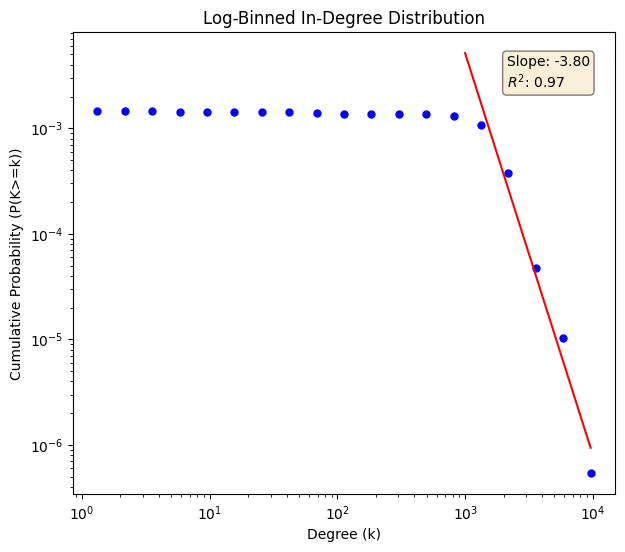

<Figure size 640x480 with 0 Axes>

In [39]:
kind = 'in'
fit_min_degree = 1e3
analyzer.plot_log_binned_degree_distribution(kind=kind,cumulative=True, 
                                             title=f'Log-Binned {kind}-Degree Distribution',
                                             fit_min_degree=fit_min_degree)
plt.savefig(f'{fig_save_dir}/{kind}-degree_distribution_log.png',dpi=dpi, bbox_inches='tight')

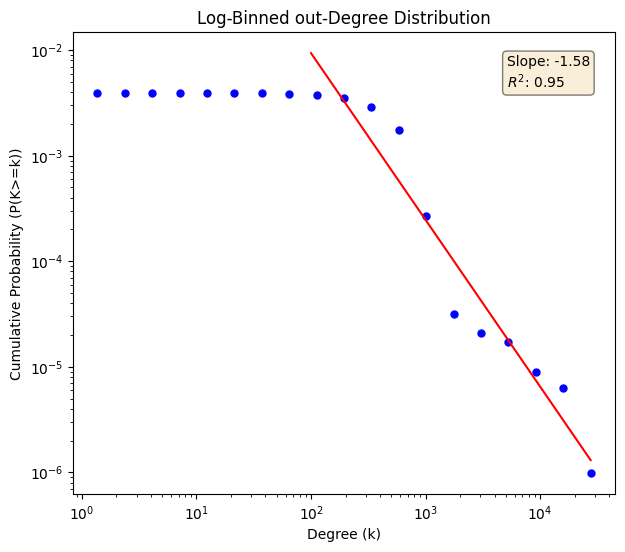

<Figure size 640x480 with 0 Axes>

In [40]:
kind = 'out'
fit_min_degree = 1e2
analyzer.plot_log_binned_degree_distribution(kind=kind,cumulative=True, 
                                             title=f'Log-Binned {kind}-Degree Distribution',
                                             fit_min_degree=fit_min_degree)
plt.savefig(f'{fig_save_dir}/{kind}-degree_distribution_log.png',dpi=dpi, bbox_inches='tight')

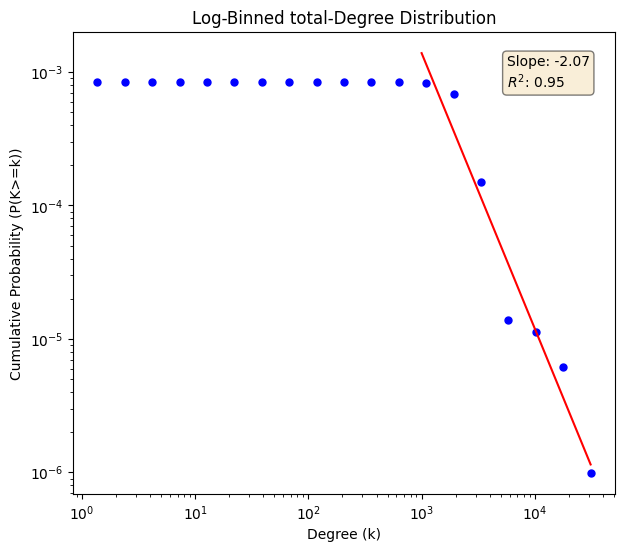

<Figure size 640x480 with 0 Axes>

In [41]:
kind = 'total'
fit_min_degree = 1e3
analyzer.plot_log_binned_degree_distribution(kind=kind,cumulative=True, 
                                             title=f'Log-Binned {kind}-Degree Distribution',
                                             fit_min_degree=fit_min_degree)
plt.savefig(f'{fig_save_dir}/{kind}-degree_distribution_log.png',dpi=dpi, bbox_inches='tight')

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter

class GraphAnalysisShort:
    def __init__(self, adjacency_matrix,kind):
        self.adjacency_matrix = adjacency_matrix
        self.degrees = self.get_degrees(kind)
        self.indegrees = self.get_degrees('in')
        self.outdegrees = self.get_degrees('out')
        self.totdegrees = self.get_degrees('total')

    def get_degrees(self, kind='in'):
        """
        Compute and return the desired degrees (in-degrees, out-degrees, or total degrees).
        """
        degrees = None
        
        if kind == 'in':
            degrees = np.array(self.adjacency_matrix.sum(axis=0)).flatten()
        elif kind == 'out':
            degrees = np.array(self.adjacency_matrix.sum(axis=1)).flatten()
        elif kind == 'total':
            in_degrees = np.array(self.adjacency_matrix.sum(axis=0)).flatten()
            out_degrees = np.array(self.adjacency_matrix.sum(axis=1)).flatten()
            degrees = in_degrees + out_degrees
        else:
            raise ValueError("Invalid degree type. Choose 'in', 'out', or 'total'.")
        
        degrees = degrees[degrees > 0]  # Remove zero degrees
        return degrees

    def plot_degree_distribution(self):
        import seaborn as sns
        degree_counts = dict(Counter(self.degrees))
        degrees = list(degree_counts.keys())
        probabilities = [val / sum(degree_counts.values()) for val in degree_counts.values()]

        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(degrees, stat='probability', kde=True, bins=30)
        plt.xlabel('Degree (k)')
        plt.ylabel('Probability (P(k))')
        plt.title('Degree Distribution')

        plt.subplot(1, 2, 2)
        log_degrees = np.log10(degrees)
        log_probabilities = np.log10(probabilities)
        sns.histplot(log_degrees, stat='probability', kde=True, bins=30)
        plt.xlabel('log(Degree)')
        plt.ylabel('log(Probability)')
        plt.title('Log-Log Plot of Degree Distribution')
        plt.show()
        
    def calculate_power_law_exponent(self):
        degree_counts = dict(Counter(self.degrees))
        degrees = list(degree_counts.keys())
        probabilities = [val / sum(degree_counts.values()) for val in degree_counts.values()]

        # we take log to perform linear regression
        log_degrees = np.log(degrees)
        log_probabilities = np.log(probabilities)

        slope, intercept, r_value, p_value, std_err = stats.linregress(log_degrees, log_probabilities)
        return slope


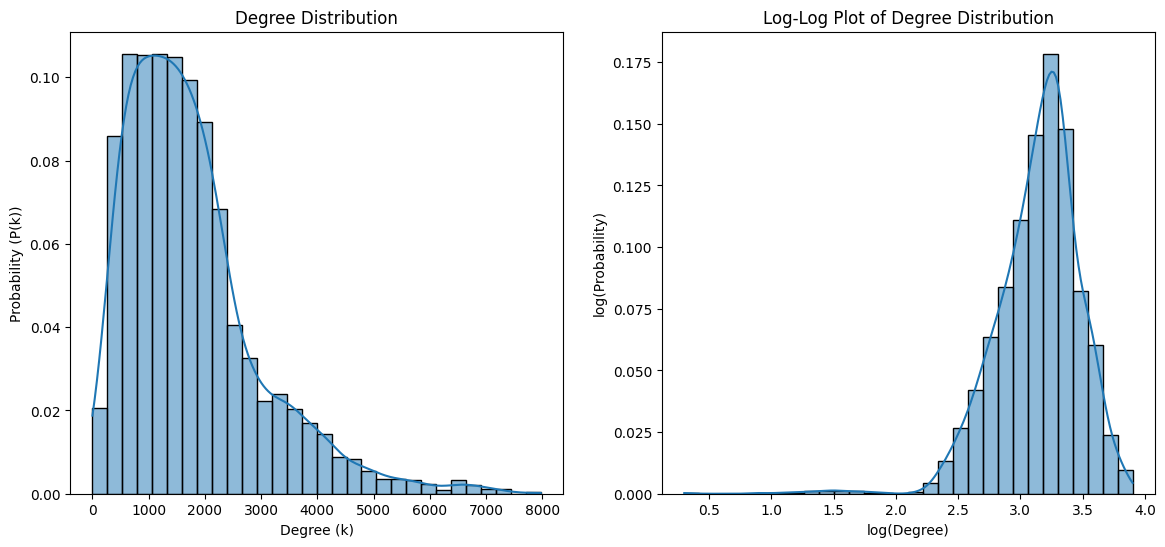

Slope of the log-log plot (Power-law exponent): -0.5035102891147885


In [228]:
# Assume that 'adjacency_matrix' is your adjacency matrix
analysis = GraphAnalysisShort(adj_matrix.A,'in')
analysis.plot_degree_distribution()
slope = analysis.calculate_power_law_exponent()
print('Slope of the log-log plot (Power-law exponent):', slope)


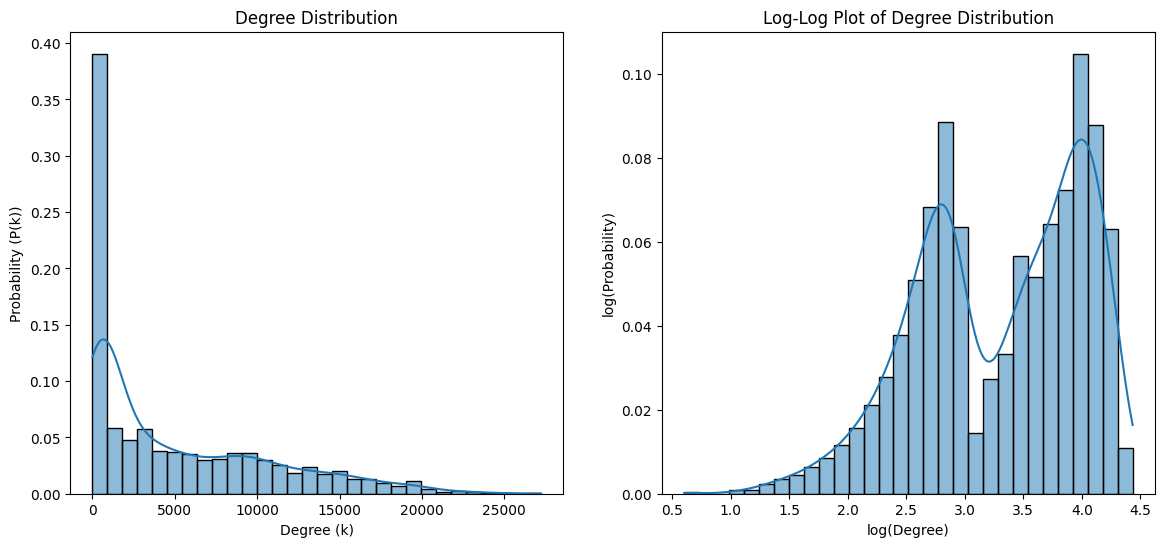

Slope of the log-log plot (Power-law exponent): -0.6010299933192348


In [229]:
# Assume that 'adjacency_matrix' is your adjacency matrix
analysis = GraphAnalysisShort(adj_matrix.A,'out')
analysis.plot_degree_distribution()
slope = analysis.calculate_power_law_exponent()
print('Slope of the log-log plot (Power-law exponent):', slope)


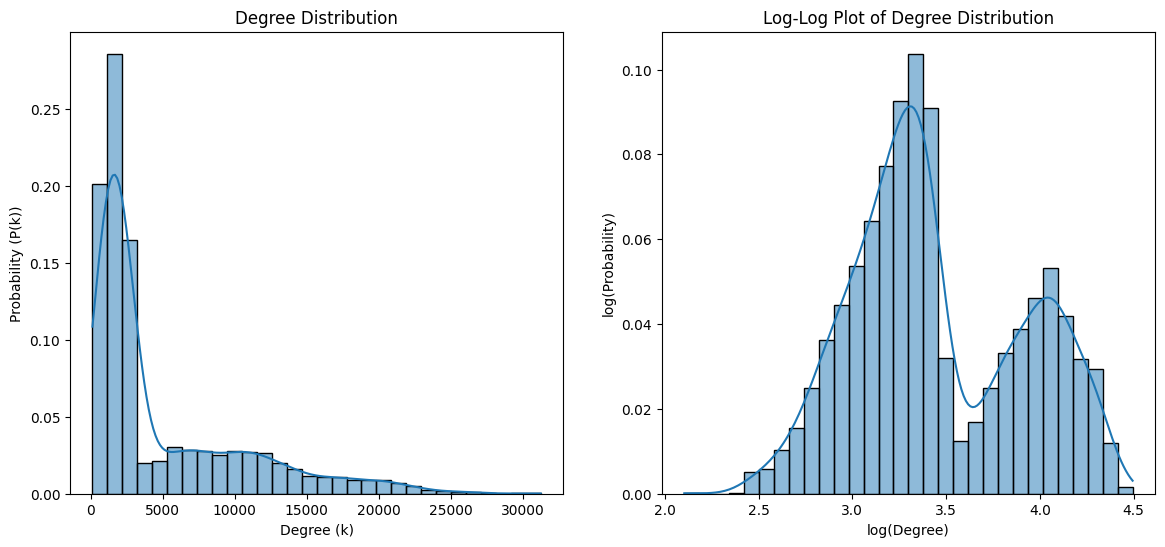

Slope of the log-log plot (Power-law exponent): -0.5317222341505327


In [230]:
# Assume that 'adjacency_matrix' is your adjacency matrix
analysis = GraphAnalysisShort(adj_matrix.A,'total')
analysis.plot_degree_distribution()
slope = analysis.calculate_power_law_exponent()
print('Slope of the log-log plot (Power-law exponent):', slope)


In [231]:
ba = igraph.Graph.Barabasi(5000,40,directed=False)
adj_ba = ba.get_adjacency_sparse()

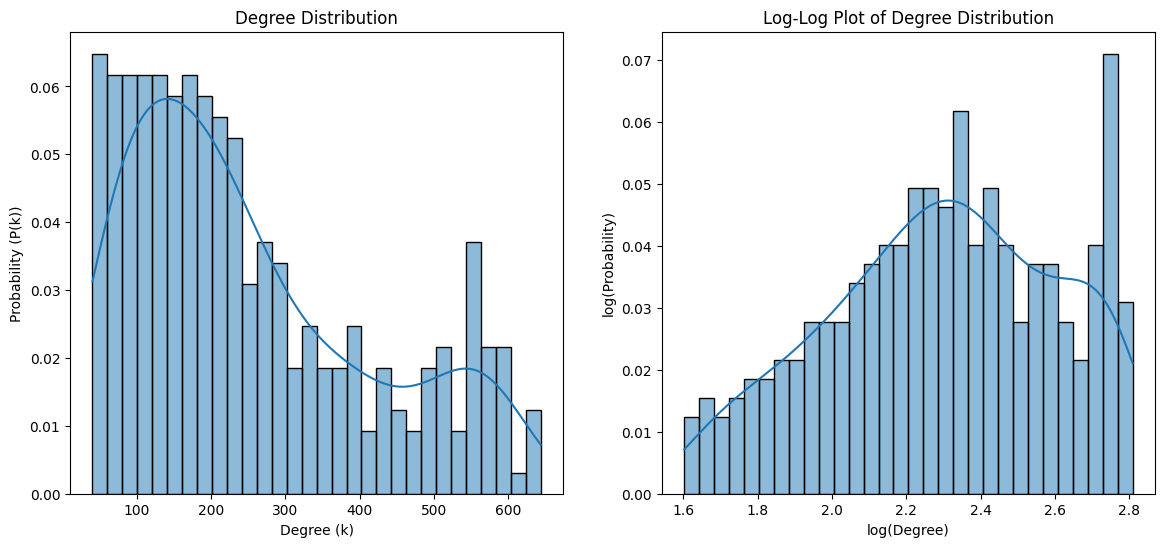

Slope of the log-log plot (Power-law exponent): -1.93112293892321


In [232]:
# Assume that 'adjacency_matrix' is your adjacency matrix
analysis = GraphAnalysisShort(adj_ba,'in')
analysis.plot_degree_distribution()
slope = analysis.calculate_power_law_exponent()
print('Slope of the log-log plot (Power-law exponent):', slope)


In [238]:
# # Find the best-fitting distributions for the outdegree distribution
# # Create an instance of DegreeDistributionAnalyzer
# analyzer = DegreeDistributionAnalyzer(adj_ba)
# best_fit_out, best_params_out, best_sse_out = analyzer.check_best_fit(distributions, kind='in')
# out_degrees = analyzer.get_degrees('in')

# print("Best fit for out-degree distribution:", best_fit_out.name)
# print("Best parameters for out-degree distribution:", best_params_out)
# print("SSE for out-degree distribution:", best_sse_out)

# # Plot the out-degree distribution
# analyzer.plot_degree_distribution(out_degrees, best_fit_out, best_params_out, best_sse_out)


Best fit for out-degree distribution: lognorm
Best parameters for out-degree distribution: (1.4253231745950141, 39.394507186138995, 15.987964092316414)
SSE for out-degree distribution: 58064779.41048741


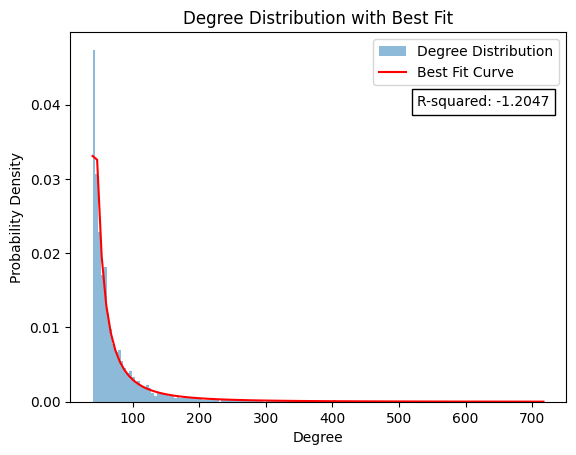

In [170]:
# Find the best-fitting distributions for the outdegree distribution
# Create an instance of DegreeDistributionAnalyzer
analyzer = DegreeDistributionAnalyzer(adj_ba)
best_fit_out, best_params_out, best_sse_out = analyzer.check_best_fit(distributions, kind='out')
out_degrees = analyzer.get_degrees('out')

print("Best fit for out-degree distribution:", best_fit_out.name)
print("Best parameters for out-degree distribution:", best_params_out)
print("SSE for out-degree distribution:", best_sse_out)

# Plot the out-degree distribution
analyzer.plot_degree_distribution(out_degrees, best_fit_out, best_params_out, best_sse_out)


In [239]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats
from collections import Counter
import seaborn as sns

class PowerLawAnalysis:
    def __init__(self, adjacency_matrix):
        self.adjacency_matrix = adjacency_matrix
        self.degrees = self.calculate_degrees()

    def calculate_degrees(self):
        # For scipy sparse matrix, convert to csr format for efficient row operations
        if hasattr(self.adjacency_matrix, "tocsr"):
            self.adjacency_matrix = self.adjacency_matrix.tocsr()
        degrees = np.array(self.adjacency_matrix.sum(axis=1)).flatten()
        return degrees

    def plot_degree_distribution(self):
        degree_counts = dict(Counter(self.degrees))
        degrees = list(degree_counts.keys())
        probabilities = [val / sum(degree_counts.values()) for val in degree_counts.values()]

        log_degrees = np.log10(degrees)
        log_probabilities = np.log10(probabilities)
        
        plt.figure(figsize=(7, 6))
        plt.scatter(log_degrees, log_probabilities, color='b', alpha=0.5, label='Data')
        
        slope, intercept = self.calculate_power_law_exponent()
        plt.plot(log_degrees, intercept + slope * log_degrees, 'r', label='Fitted line')

        plt.xlabel('log(Degree)')
        plt.ylabel('log(Probability)')
        plt.title('Log-Log Plot of Degree Distribution')
        plt.legend()
        plt.text(0.1, 0.9, f'Slope: {slope:.4f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black'))

        plt.show()

    def calculate_power_law_exponent(self):
        degree_counts = dict(Counter(self.degrees))
        degrees = list(degree_counts.keys())
        probabilities = [val / sum(degree_counts.values()) for val in degree_counts.values()]

        log_degrees = np.log10(degrees)
        log_probabilities = np.log10(probabilities)

        slope, intercept, r_value, p_value, std_err = stats.linregress(log_degrees, log_probabilities)
        return slope, intercept


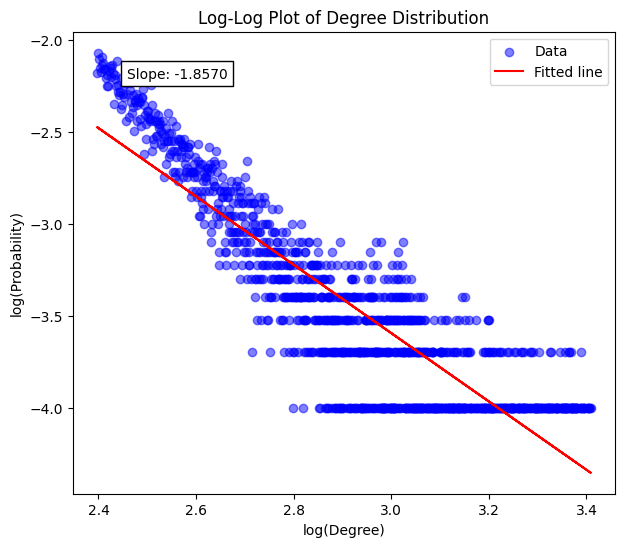

In [240]:
# Generate a scale-free network with 1000 nodes.
G = nx.barabasi_albert_graph(10000, 250)

analysis = PowerLawAnalysis(nx.adjacency_matrix(G))
analysis.plot_degree_distribution()

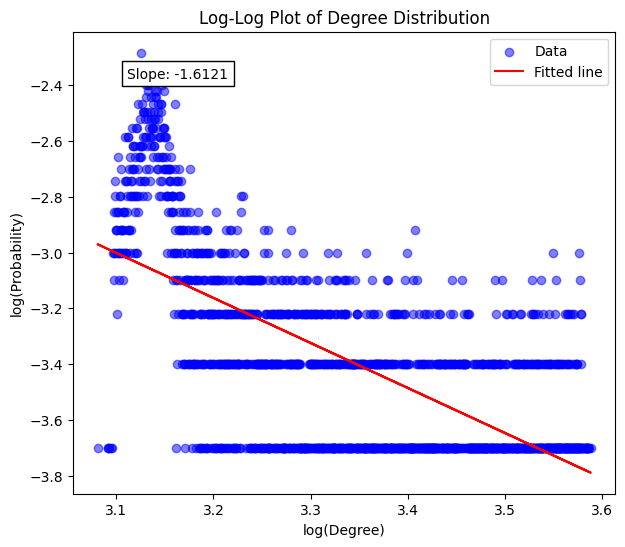

In [304]:
# Generate a scale-free network with 1000 nodes.
G = nx.barabasi_albert_graph(5000, 1250)

analysis = PowerLawAnalysis(nx.adjacency_matrix(G))
analysis.plot_degree_distribution()

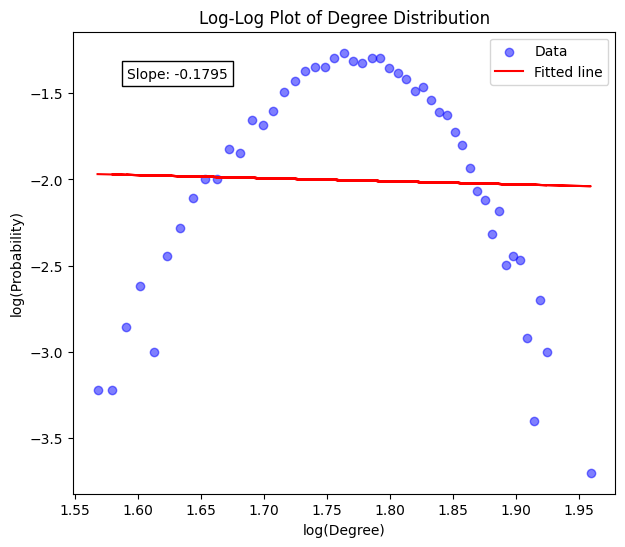

In [242]:
er = igraph.Graph.Erdos_Renyi(5000,ba.density())
analysis = PowerLawAnalysis(er.get_adjacency_sparse())
analysis.plot_degree_distribution()

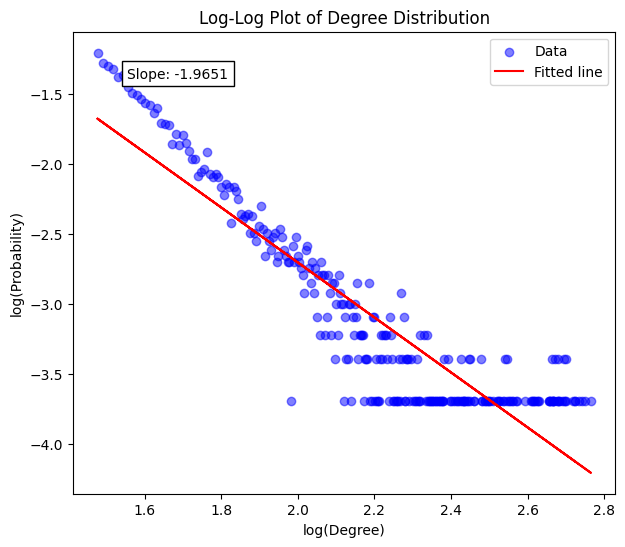

In [245]:
ba = igraph.Graph.Barabasi(5000,30,directed=False)
analysis = PowerLawAnalysis(ba.get_adjacency_sparse().tocsc())
analysis.plot_degree_distribution()

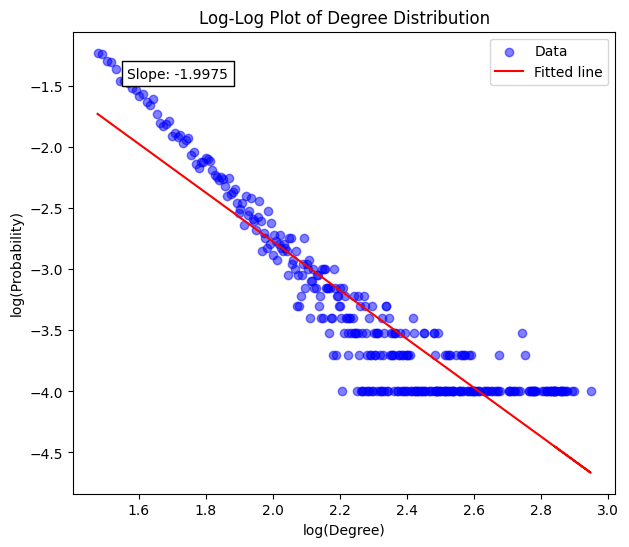

In [246]:
ba = igraph.Graph.Barabasi(10000,30,directed=False)
analysis = PowerLawAnalysis(ba.get_adjacency_sparse().tocsc())
analysis.plot_degree_distribution()

In [114]:
class GraphAnalysis:
    def __init__(self, adjacency_matrix,kind):
        self.adjacency_matrix = self.assess_input(adjacency_matrix)
        self.is_lognormal_in = None
        self.is_lognormal_out = None
        self.is_lognormal_tot = None
        self.indegrees = self.get_degrees('in')
        self.outdegrees = self.get_degrees('out')
        self.totaldegrees = self.indegrees + self.outdegrees
        self.degrees = self.get_degrees(kind)
        self.kind = kind
    
    def assess_input(self,data):
        '''
        Converts certain known classes to scipy.sparse.cscmatrix
        '''
        import numpy as np
        import igraph
        from scipy import sparse
        
        
        if isinstance(data,nx.Graph):
            return nx.adjacency_matrix(data)
        elif isinstance(data,igraph.Graph):
            return data.get_adjacency_sparse().tocsc()
        elif isinstance(data,np.ndarray):
            return sparse.csc_matrix(data)
        elif isinstance(data,sparse.csc_matrix):
            return data
        elif isinstance(data,sparse.csr_matrix):
            return data.tocsc()
        else:
            raise NotImplementedError
            
    def get_degrees(self, kind):
        """
        Compute and return the desired degrees (in-degrees, out-degrees, or total degrees).
        """
        degrees = None
        # For scipy sparse matrix, convert to csr format for efficient row operations
        if hasattr(self.adjacency_matrix, "tocsr"):
            self.adjacency_matrix = self.adjacency_matrix.tocsr()

        if kind == 'in':
            degrees = np.array(self.adjacency_matrix.sum(axis=0)).flatten()
        elif kind == 'out':
            degrees = np.array(self.adjacency_matrix.sum(axis=1)).flatten()
        elif kind == 'total':
            in_degrees = np.array(self.adjacency_matrix.sum(axis=0)).flatten()
            out_degrees = np.array(self.adjacency_matrix.sum(axis=1)).flatten()
            degrees = in_degrees + out_degrees
        else:
            raise ValueError("Invalid degree type. Choose 'in', 'out', or 'total'.")
        
        degrees = degrees[degrees > 0]  # Remove zero degrees
        return degrees

    def fit_degree_distribution(self, degrees, distributions):
        """
        Fit the degree distribution to multiple statistical distributions and determine the best fit.
        """
        best_fit = None
        best_params = None
        best_sse = np.inf
        
        for distribution in distributions:
            # Fit the distribution to the degrees
            params = distribution.fit(degrees)
            sse = self.calculate_sse(degrees, distribution, params)
            
            # Check if the current fit is better than the previous best
            if sse < best_sse:
                best_fit = distribution
                best_params = params
                best_sse = sse
        
        return best_fit, best_params, best_sse
    
    def calculate_sse(self, degrees, distribution, params):
        """
        Calculate the sum of squared errors (SSE) between the observed degrees and the fitted distribution.
        """
        fitted_degrees = distribution.pdf(degrees, *params)
        sse = np.sum((degrees - fitted_degrees) ** 2)
        return sse

    def check_best_fit(self, distributions):
        """
        Find the best-fitting distribution for the degree distribution.
        """
        degrees = self.get_degrees(self.kind)
        
        best_fit, best_params, best_sse = self.fit_degree_distribution(degrees, distributions)
        
        return best_fit, best_params, best_sse

    # def plot_degree_distribution(self, degrees, distribution, params, sse):
    #     """
    #     Plot the degree distribution along with the fitted curve and R-squared value.
    #     """
    #     plt.hist(degrees, bins='auto', density=True, alpha=0.5, label='Degree Distribution')
    #     x = np.linspace(np.min(degrees), np.max(degrees), 100)
    #     fitted_curve = distribution.pdf(x, *params)
    #     plt.plot(x, fitted_curve, 'r-', label='Best Fit Curve')
    #     plt.xlabel('Degree')
    #     plt.ylabel('Probability Density')
    #     plt.title('Degree Distribution with Best Fit')
    #     plt.legend()

    #     # Calculate R-squared value
    #     y_mean = np.mean(degrees)
    #     sst = np.sum((degrees - y_mean) ** 2)
    #     ssr = np.sum((degrees - distribution.pdf(degrees, *params)) ** 2)
    #     r_squared = 1 - (ssr / sst)
    #     plt.text(0.7, 0.8, f'R-squared: {r_squared:.4f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black'))

    #     plt.show()
    
    def check_lognormality(self,alpha=1e-3):
        """
        Check the lognormality of the in and out degree distributions using statistical methods.

        alpha : if p<alpha : reject the null hypothesis that the distribution is normal.
        """
        in_degrees, out_degrees,tot_degrees = self.get_degrees('in'),self.get_degrees('out'),self.get_degrees('total')

        # Compute log-transformed degrees
        log_in_degrees = np.log(in_degrees)
        log_out_degrees = np.log(out_degrees)
        log_tot_degrees = np.log(tot_degrees)

        # Perform statistical tests for lognormality
        in_lognormal, in_pvalue = stats.normaltest(log_in_degrees)
        out_lognormal, out_pvalue = stats.normaltest(log_out_degrees)
        tot_lognormal, tot_pvalue = stats.normaltest(log_tot_degrees)

#         print("p = {:g}".format(p))
        if in_pvalue < alpha:  # null hypothesis: x comes from a normal distribution
            print("Indegree: The null hypothesis can be rejected")
            self.is_lognormal_in = False
        else:
            print("Indegree: The null hypothesis cannot be rejected")
            self.is_lognormal_in = True

        if out_pvalue < alpha:  # null hypothesis: x comes from a normal distribution
            print("Outdegree: The null hypothesis can be rejected")
            self.is_lognormal_out = False
        else:
            print("Outdegree: The null hypothesis cannot be rejected")
            self.is_lognormal_out = True

        if tot_pvalue < alpha:  # null hypothesis: x comes from a normal distribution
            print("Total degree: The null hypothesis can be rejected")
            self.is_lognormal_tot = False
        else:
            print("Total degree: The null hypothesis cannot be rejected")
            self.is_lognormal_tot = True

        return self.is_lognormal_in,self.is_lognormal_out,self.is_lognormal_tot

    def plot_degree_distribution(self,title=None):
        degree_counts = dict(Counter(self.degrees))
        degrees = list(degree_counts.keys())
        probabilities = [val / sum(degree_counts.values()) for val in degree_counts.values()]

        log_degrees = np.log10(degrees)
        log_probabilities = np.log10(probabilities)
        
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.subplot(1, 2, 1)
        sns.histplot(degrees, stat='probability', kde=True, bins=30)
        plt.xlabel('Degree (k)')
        plt.ylabel('Probability (P(k))')
        plt.title(f'Degree Distribution: LinLin Plot')
        
        plt.subplot(1, 2, 2)
        sns.scatterplot(x=log_degrees, y=log_probabilities, color='b', alpha=0.5, label='Data')
        slope, intercept = self.calculate_power_law_exponent()
        sns.lineplot(x=log_degrees, y=intercept + slope * log_degrees, color='r', label='Fitted line')
        plt.xlabel('log(Degree)')
        plt.ylabel('log(Probability)')
        plt.title(f'Degree Distribution: LogLog Plot (Linear Binning)')

        
        plt.legend()
        plt.text(0.1, 0.9, f'Slope: {slope:.4f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black'))
        
        if title:
            plt.suptitle(title)
        else:
            plt.suptitle(f'{self.kind}-Degree Analysis')
        plt.tight_layout()
        plt.show()

    def calculate_power_law_exponent(self): # deprecated
        degree_counts = dict(Counter(self.degrees))
        degrees = list(degree_counts.keys())
        probabilities = [val / sum(degree_counts.values()) for val in degree_counts.values()]

        log_degrees = np.log10(degrees)
        log_probabilities = np.log10(probabilities)

        slope, intercept, r_value, p_value, std_err = stats.linregress(log_degrees, log_probabilities)
        return slope, intercept
    
    def plot_log_binned_degree_distribution(self, cumulative=False, title=None, fit_min_degree=10,show_plot=True):
        degree_counts = dict(Counter(self.degrees))
        max_degree = np.max(list(degree_counts.keys()))

        # Generate logarithmically spaced bins
        log_bins = np.logspace(0, np.log10(max_degree), num=20)  # Adjust num as required

        # Compute histogram with log bins
        hist, bins = np.histogram(self.degrees, bins=log_bins, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2

        if cumulative:
            hist = np.cumsum(hist[::-1])[::-1]  # Reverse, compute cumulative sum, then reverse back

        if show_plot:
            # Plot degree distribution in log-log scale
            plt.figure(figsize=(7, 6))
            plt.loglog(bin_centers, hist, 'bo', markersize=5)

        # Calculate linear regression in log-log scale for high degrees only
        fit_indices = bin_centers >= fit_min_degree
        slope, intercept, r_value, p_value, std_err = linregress(np.log10(bin_centers[fit_indices]), np.log10(hist[fit_indices]))
        x_fit = np.linspace(np.log10(fit_min_degree), np.max(np.log10(bin_centers)), num=100)
        y_fit = intercept + slope * x_fit
        if show_plot:
            plt.plot(10 ** x_fit, 10 ** y_fit, 'r-')

            # Add text box with slope and R-squared
            textstr = f'Slope: {slope:.2f}\n$R^2$: {r_value**2:.2f}'
            plt.text(0.8, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            plt.xlabel('Degree (k)')
            if cumulative:
                plt.ylabel('Cumulative Probability (P(K>=k))')
                if title:
                    plt.title(title)
                else:
                    plt.title(f'Log-Binned Cumulative {self.kind}-Degree Distribution')
            else:
                plt.ylabel('Probability (P(k))')
                if title:
                    plt.title(title)
                else:
                    plt.title(f'Log-Binned {self.kind}-Degree Distribution')

            plt.show()
        
        if show_plot:
            return slope
        else:
            return bin_centers, hist, intercept

In [104]:
import networkx as nx
import seaborn as sns

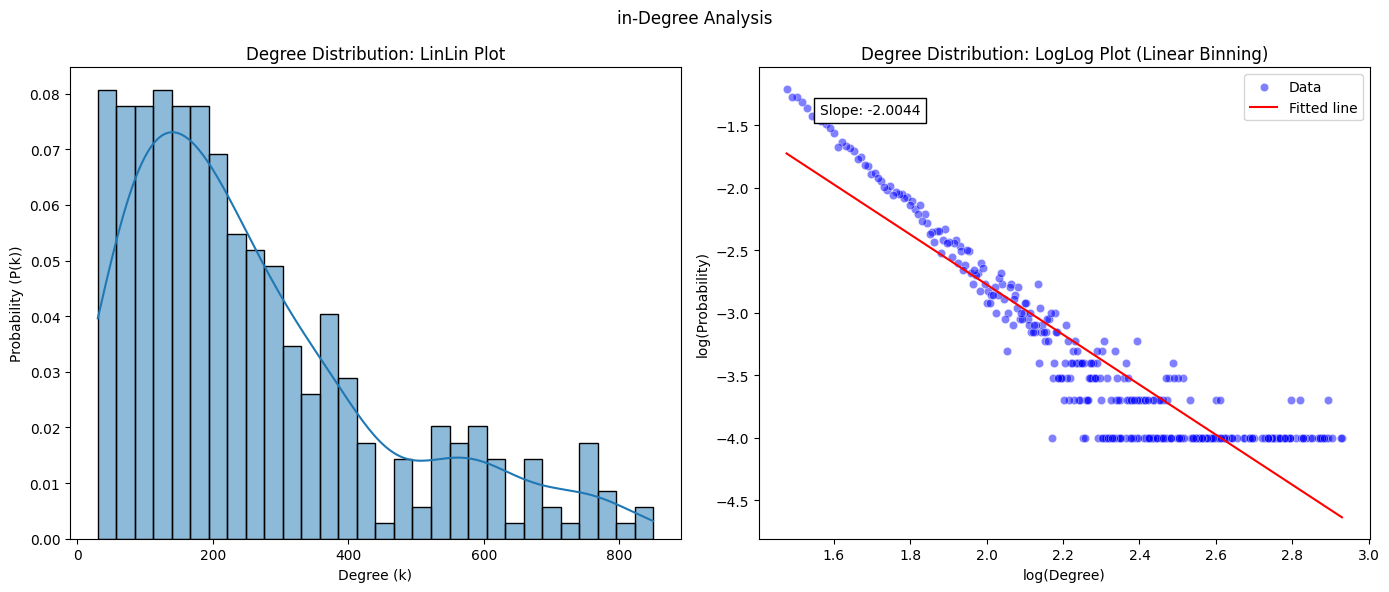

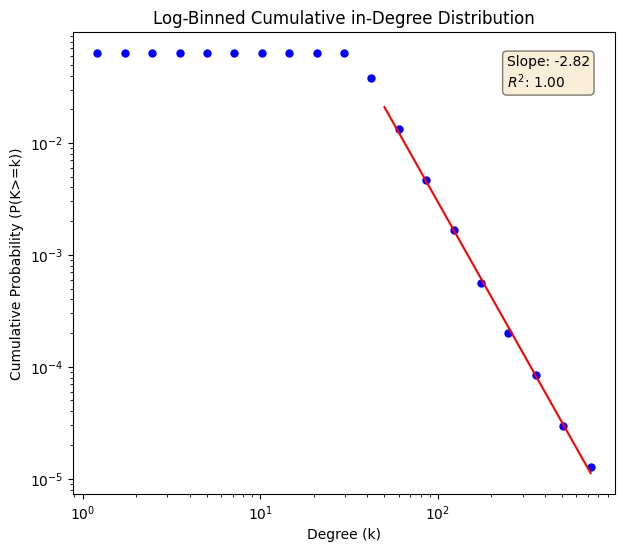

Best fit for out-degree distribution: lognorm
Best parameters for out-degree distribution: (1.45425327694258, 29.520273417878116, 11.619106126633401)
SSE for out-degree distribution: 73486045.79035367


In [117]:
ba = igraph.Graph.Barabasi(10000,30,directed=False)
analysis = GraphAnalysis(ba.to_networkx(),'in')
analysis.plot_degree_distribution()
analysis.plot_log_binned_degree_distribution(cumulative=True, 
                                             fit_min_degree=50)

from scipy.stats import norm, lognorm, expon, gamma
# Define the list of distributions to test
distributions = [norm, lognorm, expon, gamma]

best_fit, best_params, best_sse = analysis.check_best_fit(distributions)

print("Best fit for out-degree distribution:", best_fit.name)
print("Best parameters for out-degree distribution:", best_params)
print("SSE for out-degree distribution:", best_sse)

In [129]:
ba = igraph.Graph.Barabasi(5000,1250,directed=False)
analysis = GraphAnalysis(ba.to_networkx(),'in')

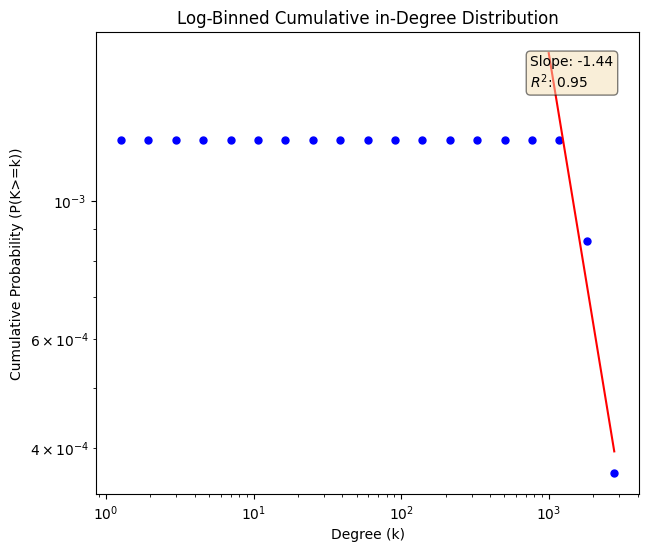

Best fit for out-degree distribution: gamma
Best parameters for out-degree distribution: (0.9850944030852447, 1249.9999999999998, 947.4952183933677)
SSE for out-degree distribution: 26673196442.745983


In [131]:
# analysis.plot_degree_distribution()
analysis.plot_log_binned_degree_distribution(cumulative=True, 
                                             fit_min_degree=1e3)

from scipy.stats import norm, lognorm, expon, gamma
# Define the list of distributions to test
distributions = [norm, lognorm, expon, gamma]

best_fit, best_params, best_sse = analysis.check_best_fit(distributions)

print("Best fit for out-degree distribution:", best_fit.name)
print("Best parameters for out-degree distribution:", best_params)
print("SSE for out-degree distribution:", best_sse)

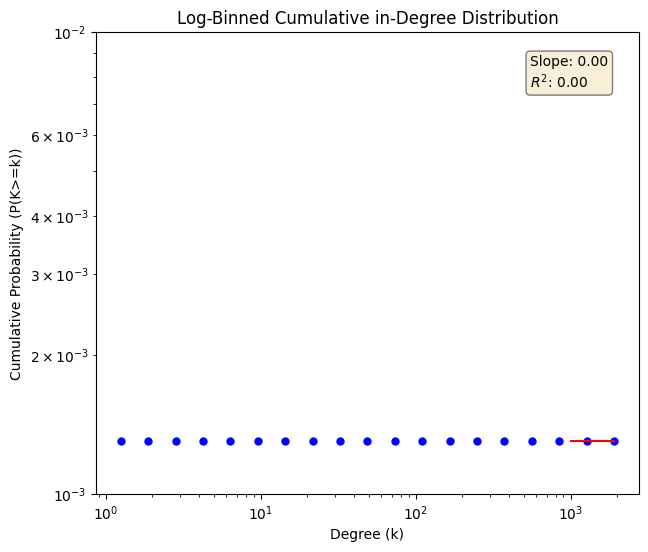

0.0

In [134]:
er = igraph.Graph.Erdos_Renyi(5000,ba.density())
analysis = GraphAnalysis(er.get_adjacency_sparse(),'in')
analysis.plot_log_binned_degree_distribution(cumulative=True, 
                                             fit_min_degree=1e3)

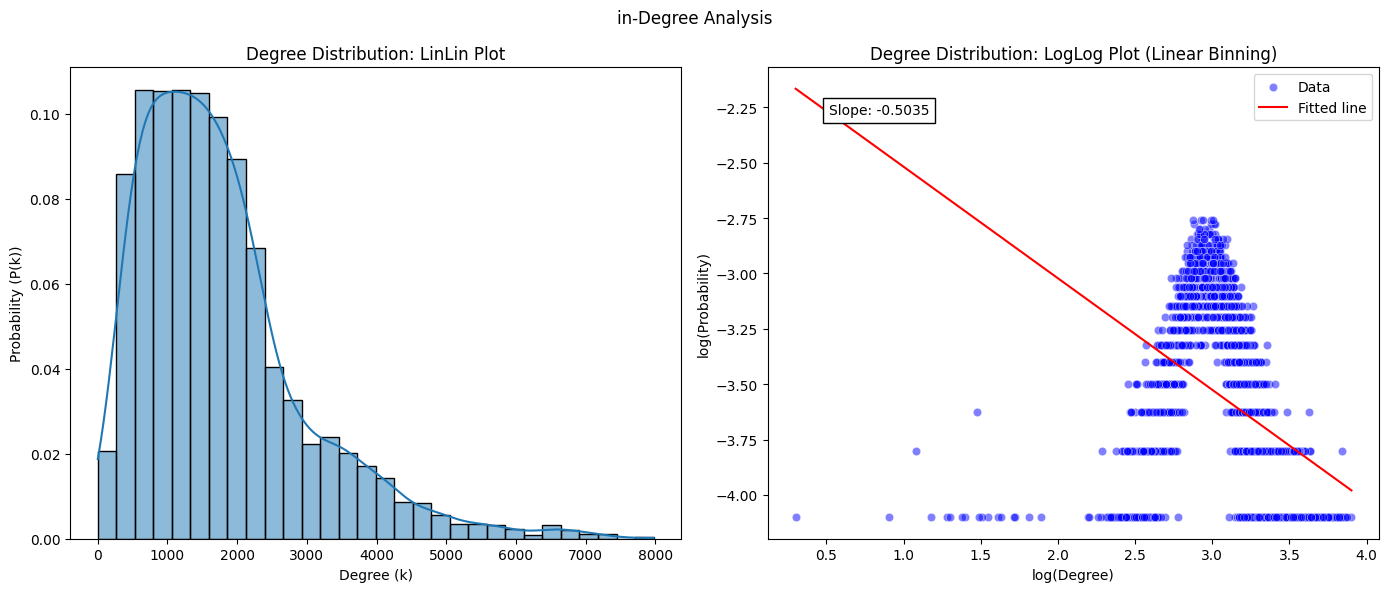

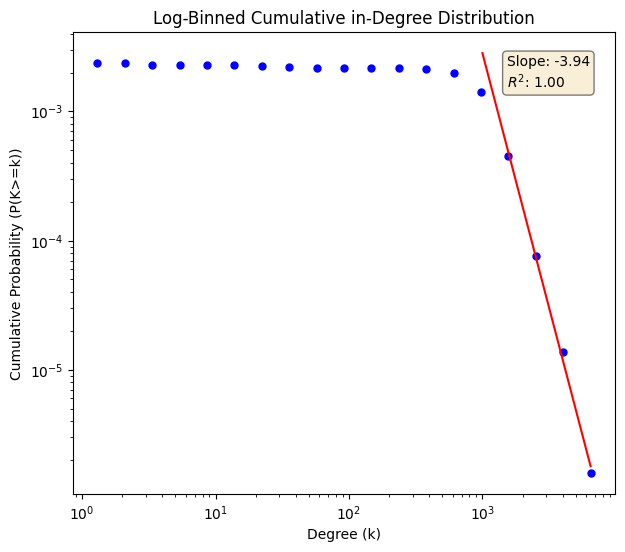

Best fit for out-degree distribution: gamma
Best parameters for out-degree distribution: (6.09783249897928, -156.80510677174783, 220.81906168954345)
SSE for out-degree distribution: 25008058005.974964


In [120]:
analysis = GraphAnalysis(adj_matrix,'in')
analysis.plot_degree_distribution()
analysis.plot_log_binned_degree_distribution(cumulative=True, 
                                             fit_min_degree=1e3)

from scipy.stats import norm, lognorm, expon, gamma
# Define the list of distributions to test
distributions = [norm, lognorm, expon, gamma]

best_fit, best_params, best_sse = analysis.check_best_fit(distributions)

print("Best fit for out-degree distribution:", best_fit.name)
print("Best parameters for out-degree distribution:", best_params)
print("SSE for out-degree distribution:", best_sse)

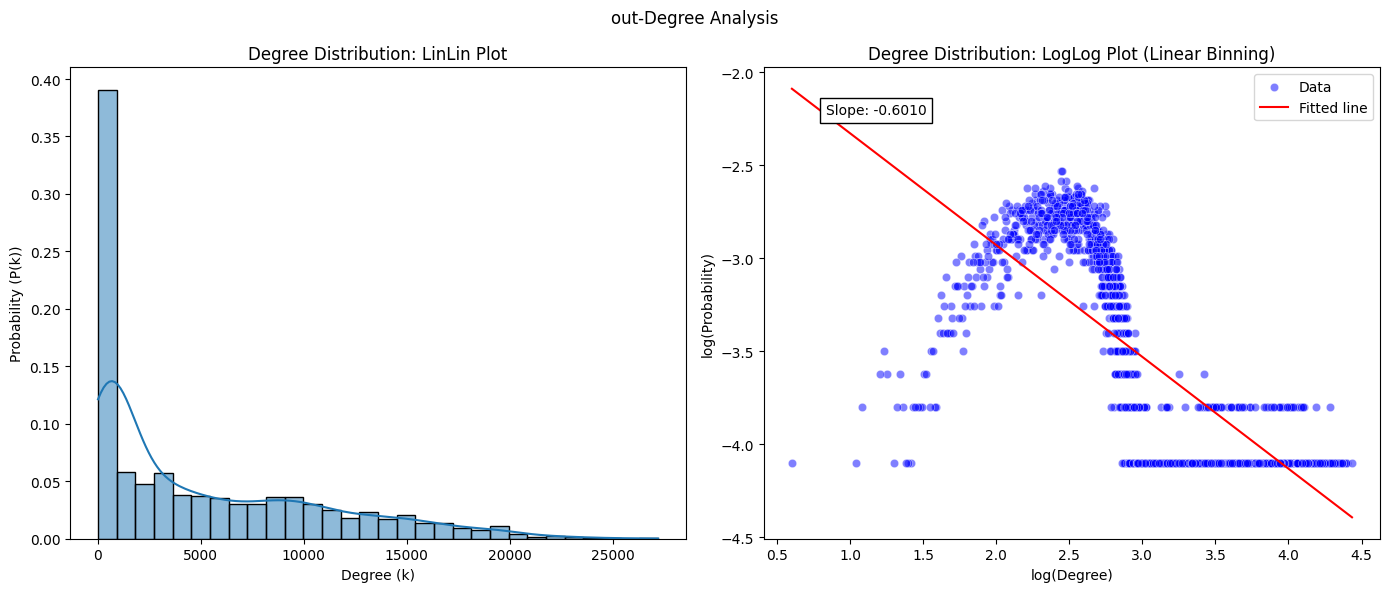

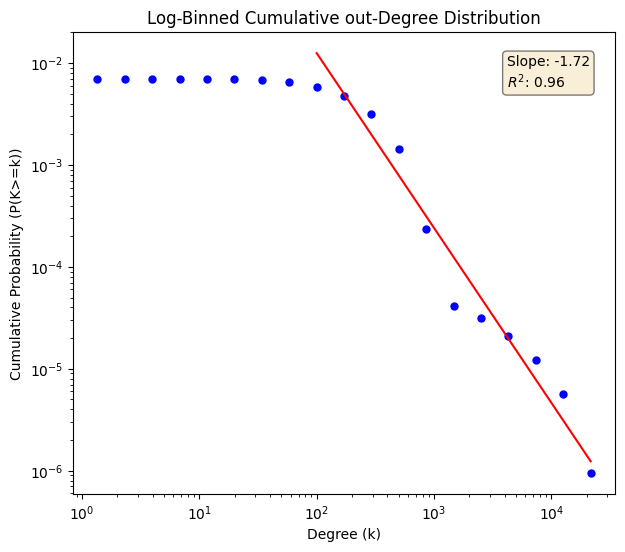

Best fit for out-degree distribution: lognorm
Best parameters for out-degree distribution: (1.1611717943152726, 3.719772217022093, 421.02652028176374)
SSE for out-degree distribution: 132065627840.07819


In [122]:
analysis = GraphAnalysis(adj_matrix,'out')
analysis.plot_degree_distribution()
analysis.plot_log_binned_degree_distribution(cumulative=True, 
                                             fit_min_degree=1e2)
from scipy.stats import norm, lognorm, expon, gamma
# Define the list of distributions to test
distributions = [norm, lognorm, expon, gamma]

best_fit, best_params, best_sse = analysis.check_best_fit(distributions)

print("Best fit for out-degree distribution:", best_fit.name)
print("Best parameters for out-degree distribution:", best_params)
print("SSE for out-degree distribution:", best_sse)

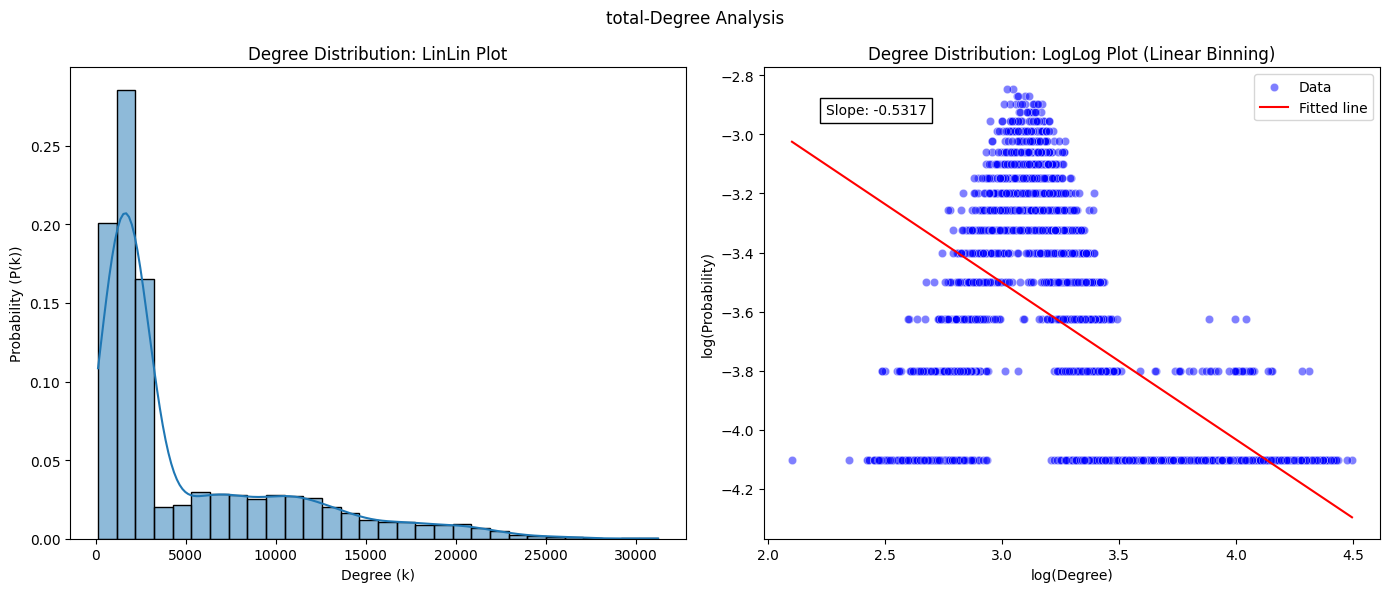

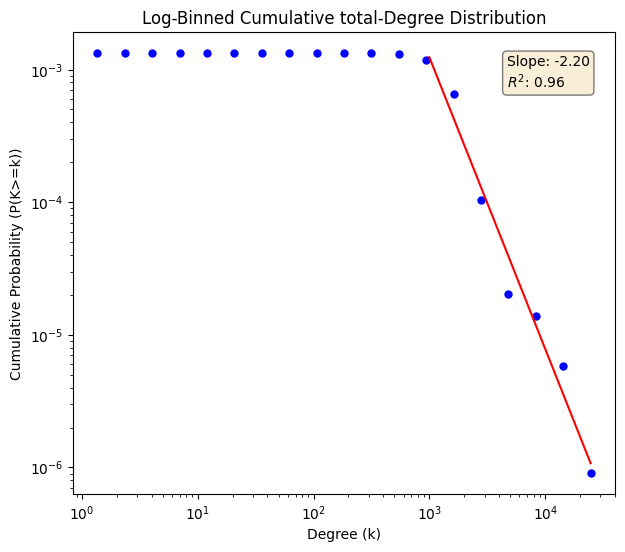

Best fit for out-degree distribution: lognorm
Best parameters for out-degree distribution: (0.7645335650099616, 124.08467400095853, 1511.8481384988854)
SSE for out-degree distribution: 219076255851.67523


In [123]:
analysis = GraphAnalysis(adj_matrix,'total')
analysis.plot_degree_distribution()
analysis.plot_log_binned_degree_distribution(cumulative=True, 
                                             fit_min_degree=1e3)

from scipy.stats import norm, lognorm, expon, gamma
# Define the list of distributions to test
distributions = [norm, lognorm, expon, gamma]

best_fit, best_params, best_sse = analysis.check_best_fit(distributions)

print("Best fit for out-degree distribution:", best_fit.name)
print("Best parameters for out-degree distribution:", best_params)
print("SSE for out-degree distribution:", best_sse)